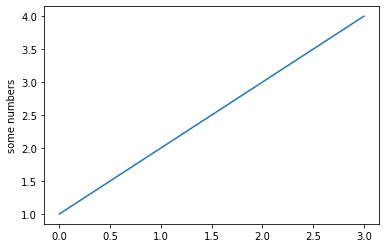

In [1]:
#Zachary Waynor 
# JupyterNotebook containing function to convert a pointcloud into a mesh useing mesh deformation


import matplotlib.pyplot as plt



#Spyder us giving an error where it will not plot unless this is here???
    
plt.plot([1, 2, 3, 4])
plt.ylabel('some numbers')
plt.show()



In [2]:
import os
import sys
import torch
!pip install pytorch3d
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes,cubify
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [3]:
def plot_pointcloud(points, title=""):
    # Sample points uniformly from the surface of the mesh.
    
    
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [4]:
def mesh_creator_deform(pointCloudMatrix):
    #takes a matrix of size [x,3] of points and deforms a sphere using chamfer_distance as the loss fucntion
    #for an optimizer to create a mesh for the pointcloud exporting 
    
    #scale and normilize vertices
    
    src_mesh = ico_sphere(4, device)
    deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

    trg_mesh = torch.tensor([pointCloudMatrix])
    target_point_count = trg_mesh.size(dim=1)
    
    #scale Fix Scale 
    #center = trg_mesh.mean(0)
    #trg_mesh = trg_mesh - center
    #scale = max(trg_mesh.abs().max(0))
    #trg_mesh = trg_mesh/ scale


    plot_pointcloud(trg_mesh, "Target Cloud")
    plot_pointcloud(sample_points_from_meshes(src_mesh, 1000), "Source mesh")

    optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

    # Number of optimization steps
    Niter = 5000
    # Weight for the chamfer loss
    w_chamfer = 2.0 
    # Weight for mesh edge loss
    w_edge = 1.0 
    # Weight for mesh normal consistency
    w_normal = 0.01 
    # Weight for mesh laplacian smoothing
    w_laplacian = 0.1 
    # Plot period for the losses
    plot_period = 250
    loop = tqdm(range(Niter))

    chamfer_losses = []
    laplacian_losses = []
    edge_losses = []
    normal_losses = []

    %matplotlib inline

    for i in loop:
        # Initialize optimizer
        optimizer.zero_grad()

        # Deform the mesh
        new_src_mesh = src_mesh.offset_verts(deform_verts)

        # We sample 5k points from the surface of each mesh 
        #sample_trg = sample_points_from_meshes(trg_mesh, 5000)
        sample_trg = trg_mesh
        sample_src = sample_points_from_meshes(new_src_mesh, 10000)

        # We compare the two sets of pointclouds by computing (a) the chamfer loss
        loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

        # and (b) the edge length of the predicted mesh
        loss_edge = mesh_edge_loss(new_src_mesh)

        # mesh normal consistency
        loss_normal = mesh_normal_consistency(new_src_mesh)

        # mesh laplacian smoothing
        loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

        # Weighted sum of the losses
        loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

        # Print the losses
        loop.set_description('total_loss = %.6f' % loss)

        # Save the losses for plotting
        chamfer_losses.append(float(loss_chamfer.detach().cpu()))
        edge_losses.append(float(loss_edge.detach().cpu()))
        normal_losses.append(float(loss_normal.detach().cpu()))
        laplacian_losses.append(float(loss_laplacian.detach().cpu()))

        # Plot mesh
        if i % plot_period == 0:
            plot_pointcloud(sample_points_from_meshes(new_src_mesh, 1000), title="iter: %d" % i)

        # Optimization step
        loss.backward()
        optimizer.step()
        
    # Fetch the verts and faces of the final predicted mesh
    final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

    # Store the predicted mesh using save_obj
    final_obj = os.path.join('./', 'final_model.obj')
    save_obj(final_obj, final_verts, final_faces)
    

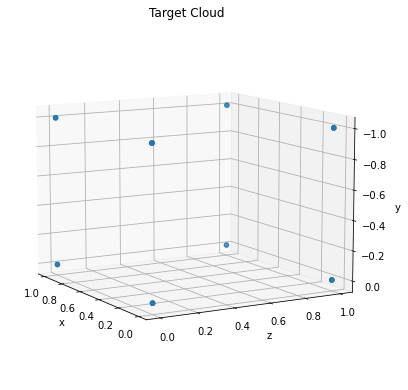

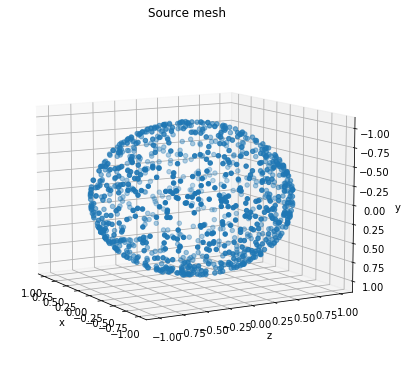

  0%|          | 0/5000 [00:00<?, ?it/s]

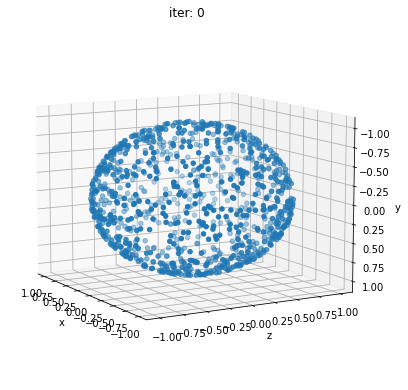

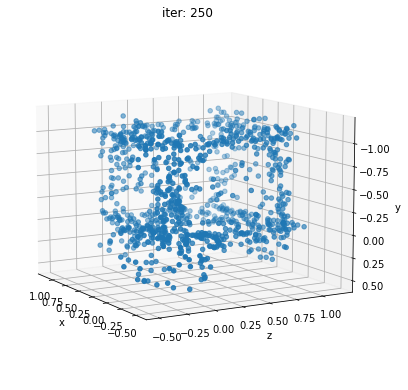

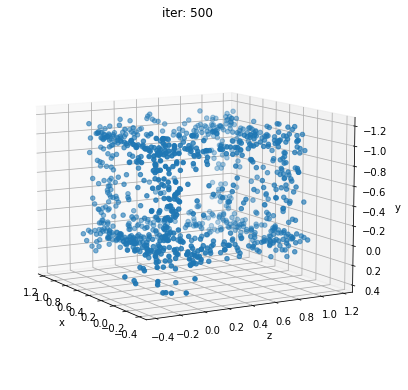

KeyboardInterrupt: 

In [7]:
#Example


pointCloudMatrix = [[0.0, 0, 0],[0, 0, 1],[0, 1, 0],[0, 1, 1],[1, 0, 0],[1, 0, 1],[1, 1, 0],[1, 1, 1],[0.0, 0, 0],[0, 0, 1],[0, 1, 0],[0, 1, 1],[1, 0, 0],[1, 0, 1],[1, 1, 0],[1, 1, 1],[0.0, 0, 0],[0, 0, 1],[0, 1, 0],[0, 1, 1],[1, 0, 0],[1, 0, 1],[1, 1, 0],[1, 1, 1],[0.0, 0, 0],[0, 0, 1],[0, 1, 0],[0, 1, 1],[1, 0, 0],[1, 0, 1],[1, 1, 0],[1, 1, 1]]

mesh_creator_deform(pointCloudMatrix)
